In [1]:
import random
import copy
import time
import asyncio
import websockets
import numpy as np

from first import get_numbers

### helper functions

In [2]:
def generate_noised_images_list(width,height,p,ethalon_matrices_list):
    """Add a noise to the ethalon images.
    Args:
        width - int
        height - int
        p - (float) probability of a noise
        ethalon_matrices_list - a list of a ethalon matrices
    Returns:
        noised_images - a list of a noised matrices, length tha same as in the 'ethalon_matrices_list'
    """
    noised_images = list()
    for matrix in ethalon_matrices_list:
        noise = np.random.choice(a=[0, 1], size=(w,h), p=[p, 1-p])
        noised_image = matrix^noise
        noised_images.append(copy.deepcopy(noised_image))
    return noised_images

def calculate_prob(x_noised,true_matrices_list_,target_index,histogram_,p_):
    """Due to the seminar notation, this fuction try to calculate p(x_noised,true_matrices_list[target_index])
    Args:
        x_noised - ndarray 100*120
        true_matrices_list - the list of 10 ndarray 100*120
        target_index - int in [0,..,9]
        p - float in [0,1]
    
    """
    xor_target = x_noised^true_matrices_list_[target_index]
    result_sum = 0
    for index_matrix,true_matrix in enumerate(true_matrices_list_):
        xor_matrix = x_noised^true_matrix
        # the equation from the seminar
        power_ = (xor_matrix - xor_target).sum()
        #print(power_)
        result_sum += histogram_[index_matrix]*((1-p_)/p_)**power_
        #print((p_/1-p_),p_/(1-p_))
        #print(p_/(1-p_),power_,np.power(p_/(1-p_),power_),histogram[index_matrix]*np.power(p_/(1-p_),power_))
    return histogram_[target_index]/result_sum


def calc_prob_list(digit_index):
    """Calculate a list of possibilities that digit_index corresponds to [0,..,9] 
    """
    possible_sum = list()
    for i in range(10):
        prob = calculate_prob(noised_images[digit_index],int_to_image_list,i,histogram,p)
        possible_sum.append(prob)
    return possible_sum

def calc_partial_sum(previous_probs_list_,current_probs_list_,t):
    """This function is convolution when dimension = 2.
    Args:
        previous_probs_list - a list of length = 9*t +1,where at position i, the probability, that the
            first (t-1) digits' sum = i
        current_probs_list_ -  a list of length = 10, ,where at position i, the probability, that the
            t-th digit equals to i
        t - int, denotes current position , we calculate sums for
    """
    predictions = list(np.zeros((9*(t+1) +1)))
    for current_value,current_prob in enumerate(current_probs_list_):
        for prev_value,prev_prob in enumerate(previous_probs_list_):
            predictions[current_value + prev_value] += current_prob*prev_prob
            #print(current_prob)
    return predictions

def sum_digits(number):
    """Calcuate the sum of digits in 'number'
    """
    digits_sum = 0
    while number:
        digits_sum += number % 10
        number //= 10
    return digits_sum

### Generate random images

In [3]:
t = 21
# distribution of digits in random_int_list(uniform)
histogram = [1/10 for i in range(10)]
#histogram = [0.5,0.5,0,0,0,0,0,0,0,0]
random_int_list = np.random.choice(a=[0,1,2,3,4,5,6,7,8,9],size=t,p=histogram)
print(random_int_list)
print(histogram)

[7 3 0 3 9 8 9 7 2 3 2 4 0 8 5 5 7 1 7 6 9]
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


### Convert digit to an image

In [10]:
# default width = 3, height = 5
width_scale = 40
height_scale = 40
# list, at which on a position i, array which represents i
try:
    int_to_image_list = asyncio.get_event_loop().run_until_complete(get_numbers(1,1))
except:
    int_to_image_list = await (get_numbers(1,1))

for i in range(len(int_to_image_list)):
    int_to_image_list[i] = copy.deepcopy(np.repeat(
        np.repeat(int_to_image_list[i],width_scale,axis=0),height_scale,axis=1))
# random_int_list - list of random digits, e.g. [4,5,6,8]
ethalon_matrices_list = [copy.deepcopy(int_to_image_list[random_int]) for random_int in random_int_list]
print("Each image has a shape : ",ethalon_matrices_list[0].shape)

Each image has a shape :  (200, 120)


### Add a noise

In [5]:
w, h = 5*height_scale,3*width_scale
p = 0.2
# adding noise to the 'ethalon_matrices_list'
noised_images = generate_noised_images_list(w,h,p,ethalon_matrices_list)
print("noised_images.shape :",noised_images[0].shape)
print("a length of noised_images :",len(noised_images))

noised_images.shape : (200, 120)
a length of noised_images : 21


### noised_images[0]

In [6]:
start_time = time.time()
# up to 't' numbers calculate sum
for current_t in range(0,t):
    if current_t == 0 : 
        previous_probs_list = calc_prob_list(0)
    else:
        next_probs_list = calc_prob_list(current_t)
        previous_probs_list = calc_partial_sum(previous_probs_list,next_probs_list,current_t)
end_time = time.time()
print("elapsed time : ",end_time - start_time)

elapsed time :  0.15262603759765625


c:\install\python\python36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in power


In [7]:
print("predicted sum : ",np.array(previous_probs_list).argmax())
print("real sum : ",np.sum(np.array(random_int_list[:t])).sum())

predicted sum :  105
real sum :  105


### Check is sum is divided by 3

In [8]:
prob_is_divided = 0
prob_is_not_divided = 0
for digits_sum,prob in enumerate(previous_probs_list):
    if digits_sum % 3 == 0:
        prob_is_divided += prob
    else :
        prob_is_not_divided += prob

if prob_is_divided > prob_is_not_divided:
    print("Our sum is divided by 3 without a residual")
else :
    print("Our sum is divided by 3 with a residual")

Our sum is divided by 3 without a residual


## check trivial case(t=21) and p=0.5. amount of 1 and 0's are binomial

In [11]:
t = 21
# distribution of digits in random_int_list(uniform)
histogram = [0.5,0.5,0,0,0,0,0,0,0,0]
random_int_list = np.random.choice(a=[0,1,2,3,4,5,6,7,8,9],size=t,p=histogram)
print(random_int_list)
print(histogram)
# default width = 3, height = 5
width_scale = 1
height_scale = 1
# list, at which on a position i, array which represents i
try:
    int_to_image_list = asyncio.get_event_loop().run_until_complete(get_numbers(1,1))
except:
    int_to_image_list = await (get_numbers(1,1))
for i in range(len(int_to_image_list)):
    int_to_image_list[i] = np.repeat(
        np.repeat(int_to_image_list[i],width_scale,axis=0),height_scale,axis=1)
# random_int_list - list of random digits, e.g. [4,5,6,8]
ethalon_matrices_list = [int_to_image_list[random_int] for random_int in random_int_list]
print("Each image has a shape : ",ethalon_matrices_list[0].shape)
w, h = 5*height_scale,3*width_scale
p = 0.5
# adding noise to the 'ethalon_matrices_list'
noised_images = generate_noised_images_list(w,h,p,ethalon_matrices_list)
print("noised_images.shape :",noised_images[0].shape)
print("a length of noised_images :",len(noised_images))
#####
print("amount of 1 : ",noised_images[0][noised_images[0]==1].sum())
print("amount of 0 : ",w*h-noised_images[0][noised_images[0]==1].sum())
start_time = time.time()
# up to 't' numbers calculate sum
for current_t in range(0,t):
    if current_t == 0 : 
        previous_probs_list = calc_prob_list(0)
    else:
        next_probs_list = calc_prob_list(current_t)
        previous_probs_list = calc_partial_sum(previous_probs_list,next_probs_list,current_t)
end_time = time.time()
print("elapsed time : ",end_time - start_time)

[1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1]
[0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Each image has a shape :  (5, 3)
noised_images.shape : (5, 3)
a length of noised_images : 21
amount of 1 :  9
amount of 0 :  6
elapsed time :  0.020977020263671875


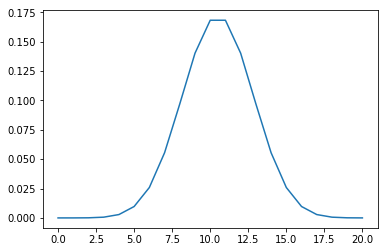

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.plot(np.arange(21),np.array(previous_probs_list[:21]))
plt.show()